In [1]:
import sys
sys.path.append('..')
from visualization.utils import sample_masks, show_slices
from pathlib import Path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# Table of Contents <a class="anchor" id="top"></a>
* [Summary dictionary](#summary)  
* [Problems summary](#problems)
* [Brain Tumour](#brain)  
* [Heart](#heart)  
* [Hippocampus](#hippocampus) 
* [Prostate](#prostate)
* [Lung](#lung)
* [Pancreas](#pancreas)
* [Hepatic Vessel](#vessel)
* [Spleen](#spleen)
* [Colon](#colon)

# Summary dictionary <a class="anchor" id="summary"></a>

In [2]:
TASKS = {
    "Task01_BrainTumour": {"name": "brain", 
                           "classes": ["edema", "ne_tumour", "e_tumour"], 
                           "modes": ["FLAIR", "T1w", "t1gd","T2w"],
                           "include_modes": [True, True, True, True],
                           "thresholds": [1000,400,600]},
    
    "Task02_Heart": {"name": "heart", 
                     "classes": [""], 
                     "modes": [""],
                     "include_modes": [True],
                     "thresholds": [700]},
    
    "Task04_Hippocampus": {"name": "hippocampus", 
                           "classes": ["anterior", "posterior"],
                           "modes": [""],
                           "include_modes": [True],
                           "thresholds": [100, 100]},
    
    "Task05_Prostate": {"name": "prostate", 
                        "classes": ["peripheral", "transitional"],
                        "modes": ["T2","ADC"],
                        "include_modes": [True, False],
                        "thresholds": [300,600]},
    
    "Task06_Lung": {"name": "lung", 
                    "classes": [""],
                    "modes": [""],
                    "include_modes": [True],
                    "thresholds": [1000]},
    
    "Task07_Pancreas": {"name": "pancreas",
                        "classes": ["", "cancer"],
                        "modes": [""],
                        "include_modes": [True],
                        "thresholds": [200, 200]},
    
    "Task08_HepaticVessel": {"name": "vessel",
                             "classes": ["", "cancer"],
                             "modes": [""],
                             "include_modes": [True],
                             "thresholds": [200, 500 ]},
    
    "Task09_Spleen": {"name": "spleen", 
                      "classes": [""],
                      "modes": [""],
                      "include_modes": [True],
                      "thresholds": [600]},
    
    "Task10_Colon": {"name": "colon", 
                     "classes": [""],
                     "modes": [""],
                     "include_modes": [True],
                     "thresholds": [400]}    
}

In [3]:
print(TASKS.keys())

dict_keys(['Task01_BrainTumour', 'Task02_Heart', 'Task04_Hippocampus', 'Task05_Prostate', 'Task06_Lung', 'Task07_Pancreas', 'Task08_HepaticVessel', 'Task09_Spleen', 'Task10_Colon'])


In [4]:
root = Path().cwd().parent
root
root_dir = Path.cwd().parent / "data" / "organs"

In [5]:
root_dir.name

'organs'

In [6]:
from skimage.transform import resize
from skimage.io import imsave

def save_or_reject(image, mask, root_dir, threshold):
    return True

# processes just one volume
def convert_and_save(image_volume, mask_volume, task_metadata, size=(256, 256), root_dir=Path().cwd().parent / "data" / "organs"):
    base_name = (image_volume.name).split(".")[0]
    volume = nib.load(str(image_volume)).get_fdata()
    mask = nib.load(str(mask_volume)).get_fdata()
    # check that number of slices is that same in image and mask
    n_slices = mask.shape[2]
    assert volume.shape[2] == mask.shape[2]
    
    # split into volumes by mode
    volumes_by_mode = []
    if len(task_metadata["modes"])> 1:
        for i in range(len(task_metadata["modes"])):
            if task_metadata["include_modes"][i]:
                single_mode_volume = volume[:,:,:,i]
                volumes_by_mode.append(single_mode_volume)
            else:
                volumes_by_mode.append(None)            
    else:
        volumes_by_mode = [volume]
    print("Task {}".format(task_metadata["name"]))
    for i, mode in enumerate(task_metadata["modes"]):
        if task_metadata["include_modes"][i]:
            volume_i = volumes_by_mode[i]
            for j in range(n_slices):
                # get slice
                image_slice = volume_i[:,:,j]
                image_resized = resize(image_slice, size)
                mask_slice = mask[:,:,j]
                assert image_slice.shape == mask_slice.shape
                # here the fun with different things on one image starts: 
                for k, subtask in enumerate(task_metadata["classes"]):
                    directory_name = (task_metadata["name"] + 
                                      ("_" + subtask if subtask != "" else "") + 
                                      ("_" + mode if mode != "" else ""))
                    # define target directories (depend on the subtask)
                    image_target_dir = root_dir / directory_name / "images"
                    mask_target_dir = root_dir / directory_name / "masks"
                    # check if the mask satisfies threshold
                    add_slice = (mask_slice == (k+1)).sum() >= task_metadata["thresholds"][k]
                    if add_slice: 
                        image_target = image_target_dir / (base_name + "_slice" + str(j) + ".jpg")
                        mask_target = mask_target_dir / (base_name + "_slice" + str(j) + ".jpg")
                        print("Slice should be added")
                        k_mask = mask_slice.copy()
                        # zero everything that's not region of interest
                        k_mask[k_mask != (k+1)] = 0
                        k_mask[k_mask == (k+1)] = 1
                        k_mask = resize(k_mask, size)
                        # EDIT HERE
                        #imsave(str(image_target_path), image_slice)
                        #imsave(str(mask_target_path), mask_slice)
                        print("We are going to save image {} with shape {},\nmask with shape {}, to {} and {}".
                              format(base_name, str(image_resized.shape), 
                                     str(k_mask.shape), str(image_target), str(mask_target)))
                        imsave(str(image_target), image_resized)
                        imsave(str(mask_target), k_mask)
                    else:
                        # TODO: count ignored slices
                        print("--")
                        print("No, should not be added")
                    print("Subtask {} with values {}".format(directory_name,k+1))

    
count = 0
for key in TASKS:
    path = root / key
    images_path = path / "imagesTr"
    masks_path = path / "labelsTr"
    target_dir_root = root / "data" / "organs" 
    target_dir_root.mkdir(exist_ok = True)
    # create necessary directories structure
    for subtask in TASKS[key]["classes"]:
        # generate directories for subtask
        subtask_global_name = TASKS[key]["name"] + (("_" + subtask) if subtask!="" else "")
        for (mode, include) in zip(TASKS[key]["modes"], TASKS[key]["include_modes"]):
            if include: 
                subtask_name = subtask_global_name + (("_" + mode) if mode != "" else "")
                subtask_directory = target_dir_root / subtask_name
                subtask_directory.mkdir(exist_ok = True)
                subtask_directory_images = subtask_directory / "images"
                subtask_directory_images.mkdir(exist_ok = True)
                subtask_directory_masks = subtask_directory / "masks"
                subtask_directory_masks.mkdir(exist_ok = True)      

    # get paths to raw images and masks
    images_file_paths = images_path.glob("**/*.nii.gz")
    masks_file_paths = masks_path.glob("**/*.nii.gz")
    for path in images_file_paths:
        parts = str(path).split("\\")
        if not (path.name).startswith("._"):
            # file name - must be the same for masks and image
            image_base_name = (path.name).split(".")[0]
            image_path = images_path / (image_base_name + ".nii.gz")
            mask_path = masks_path / (image_base_name + ".nii.gz")
            convert_and_save(image_path, mask_path, TASKS[key])
            break
    # process labels first to decide, which images and in which dimension are going

Task brain
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not b

Lossy conversion from float64 to uint8. Range [0.0, 1341.6328125]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Ana\anaconda3\envs\maml_base\lib\site-packages\ipykernel_launcher.py:63: UserWarning: C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice42.jpg is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1351.046875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1347.0664062500016]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uin

--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added


Lossy conversion from float64 to uint8. Range [0.0, 1246.7382812500005]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1243.1259765625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1352.940429687498]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1529.243164062502]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to 

Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice46.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice46.jpg
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice47.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice47.jpg
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS

Lossy conversion from float64 to uint8. Range [0.0, 1348.0751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1348.0751953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1571.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1571.5]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lo

Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice53.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice53.jpg
Subtask brain_ne_tumour_FLAIR with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\images\BRATS_001_slice53.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\masks\BRATS_001_slice53.jpg
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice54.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\

Lossy conversion from float64 to uint8. Range [0.0, 1599.4013671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1557.3671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1557.3671875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1525.7216796875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this

Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice59.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice59.jpg
Subtask brain_ne_tumour_FLAIR with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\images\BRATS_001_slice59.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\masks\BRATS_001_slice59.jpg
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brai

Lossy conversion from float64 to uint8. Range [0.0, 1620.2646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1620.2646484375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1617.53125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1617.53125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this war

Subtask brain_ne_tumour_FLAIR with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\images\BRATS_001_slice64.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\masks\BRATS_001_slice64.jpg
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice65.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice65.jpg
Subtask brain_ne_tumour_FLAIR with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_FLAIR\images\BRATS_001_slice65.jpg and C:\Users\Ana\TUM

Lossy conversion from float64 to uint8. Range [0.0, 1738.5126953125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1755.5693359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1755.5693359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1740.5078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress t

Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice70.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice70.jpg
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\images\BRATS_001_slice71.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\masks\BRATS_001_slice71.jpg
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_t

Lossy conversion from float64 to uint8. Range [0.0, 1770.095703125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1770.095703125]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Ana\anaconda3\envs\maml_base\lib\site-packages\ipykernel_launcher.py:63: UserWarning: C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice76.jpg is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1684.2861328125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to u

We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\images\BRATS_001_slice76.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\masks\BRATS_001_slice76.jpg
Subtask brain_edema_FLAIR with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\images\BRATS_001_slice76.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_FLAIR\masks\BRATS_001_slice76.jpg
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\images\BRATS_001_slice77.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\masks\BRATS_001_slice77.jpg
Subtask 

Lossy conversion from float64 to uint8. Range [0.0, 1138.826171875]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1094.56640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1078.806640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1101.0673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress th

We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\images\BRATS_001_slice85.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\masks\BRATS_001_slice85.jpg
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\images\BRATS_001_slice86.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_edema_FLAIR\masks\BRATS_001_slice86.jpg
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with 

--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added
Subtask brain_edema_FLAIR with values 1
--
No, should not be added
Subtask brain_ne_tumour_FLAIR with values 2
--
No, should not be added
Subtask brain_e_tumour_FLAIR with values 3
--
No, should not be added


Lossy conversion from float64 to uint8. Range [0.0, 1206.111328125]. Convert image to uint8 prior to saving to suppress this warning.
C:\Users\Ana\anaconda3\envs\maml_base\lib\site-packages\ipykernel_launcher.py:63: UserWarning: C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\masks\BRATS_001_slice42.jpg is a low contrast image
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1236.67578125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1180.55078125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8.

--
No, should not be added
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
--
No, should not be added
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
--
No, should not be added
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
--
No, should not be added
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
--
No, should not be added
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with

Lossy conversion from float64 to uint8. Range [0.0, 1546.673828125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1558.03125]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1575.412109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1575.412109375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this w

Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\images\BRATS_001_slice47.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\masks\BRATS_001_slice47.jpg
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\images\BRATS_001_slice48.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\masks\BRATS_001_slice48.jpg
Subtask brain_ne_tumour_T1w with values 2
--
No, should not be added
Subta

Lossy conversion from float64 to uint8. Range [0.0, 1539.853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1539.853515625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1650.625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1650.625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


--
No, should not be added
Subtask brain_edema_T1w with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\images\BRATS_001_slice53.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\masks\BRATS_001_slice53.jpg
Subtask brain_ne_tumour_T1w with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_T1w\images\BRATS_001_slice53.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_T1w\masks\BRATS_001_slice53.jpg
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\images\BRATS_001_slice54.jpg and C:\Users\A

Lossy conversion from float64 to uint8. Range [0.0, 1614.5166015625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1601.4931640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1601.4931640625]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0.0, 1578.8193359375]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppres

Subtask brain_ne_tumour_T1w with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_T1w\images\BRATS_001_slice58.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_T1w\masks\BRATS_001_slice58.jpg
Subtask brain_e_tumour_T1w with values 3
--
No, should not be added
Subtask brain_edema_T1w with values 1
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\images\BRATS_001_slice59.jpg and C:\Users\Ana\TUM\reptile\data\organs\brain_ne_tumour_T1w\masks\BRATS_001_slice59.jpg
Subtask brain_ne_tumour_T1w with values 2
Slice should be added
We are going to save image BRATS_001 with shape (256, 256),
mask with shape (256, 256), to C:\Users\Ana\TUM\reptile\data\organs\brain_e_tumour_T1w\images\BRATS_001_slice59.jpg and C:\Users\Ana\TUM\reptile\data\orga

KeyboardInterrupt: 

In [7]:
paths = {}
for key in TASKS.keys():
    path_to_masks = Path.cwd().parent / key / 'labelsTr' 
    all_masks = list(path_to_masks.glob("**/*.nii.gz"))
    sample_volume = all_masks[len(all_masks)//2]
    paths[TASKS[key]["name"]] = sample_volume

In [8]:
im_paths = {}
for key in TASKS.keys():
    path_to_images = Path.cwd().parent / key / 'imagesTr' 
    all_images = list(path_to_images.glob("**/*.nii.gz"))
    sample_volume = all_images[len(all_images)//2]
    im_paths[TASKS[key]["name"]] = sample_volume

# Problems summary <a class="anchor" id="problems"></a>

### Problem 1: Lungs regions are sometimes too small
Lungs often have too small regions, checked for different volumes to verify. 

**Conclusion**. If cancer is small, the mask, of course will be very small. If we exclude them, masks will be better. However, from the medial point of view, we are interested exactly in these small regions.

### Problem 2: Prostate: peripheral zone is too tiny
**Conclusion**. Maybe makes sense to just merge them?

# BrainTumour<a class="anchor" id="brain"></a>
[To top](#top)

In [9]:
mask = nib.load(paths["brain"]).get_fdata().astype(np.float32).squeeze()
mask.shape

(240, 240, 155)

In [10]:
im = nib.load(im_paths["brain"]).get_fdata()
im.shape

(240, 240, 155, 4)

In [11]:
flair = im[:,:,:,0]
t1W = im[:,:,:,1]
t1gd = im[:,:,:,2]
t2W = im[:,:,:,3] 
print(flair.min(), flair.max())
print(t1W.min(), t1W.max())
print(t1gd.min(), t1gd.max())
print(t2W.min(), t2W.max())

0.0 1748.0
0.0 1806.0
0.0 2358.0
0.0 1582.0


In [12]:
def normalize_01(slice_, min_=-1000, max_=400):
    slice_ = (slice_- min_)/(max_-min_)
    slice_[slice_>1] = 1.0
    slice_[slice_<0] = 0.0
    return slice_

In [16]:
imsave("brain.tiff",normalize_01(flair[:,:,70],0,1500))
outp = normalize_01(flair[:,:,70],0,1500)

In [17]:
for i in range(outp.shape[0]):
    for j in range(outp.shape[1]):
        if (type(outp[i,j])!=type(flair[i,j,70])):
            print("here")

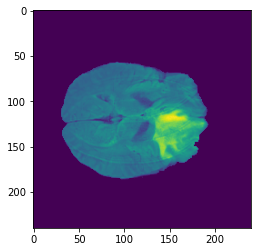

In [18]:
sample_flair = flair[:,:,70]
plt.imshow(sample_flair)

In [19]:
plt.imsave("sample_flair.jpg", sample_flair)
from skimage.io import imsave
imsave("sample_flair2.jpg", sample_flair)

Lossy conversion from float64 to uint8. Range [0.0, 1491.0]. Convert image to uint8 prior to saving to suppress this warning.


In [20]:
im_z = nib.load(im_paths["brain"])

In [21]:
print(im_z.header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  4 240 240 155   4   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1. 1. 1. 1. 1. 0. 0. 0.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b'5.0.10'
aux_file        : b'none'
qform_code      : scanner
sform_code      : scanner
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [1. 0. 0. 0.]
srow_y     

In [22]:
slices_sep, slices_all = sample_masks(paths["brain"], max_samples=None, 
                                      distinct_values=4, show = False,
                                     thresholds=[1000,400,600])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

## All regions
[To top](#top)

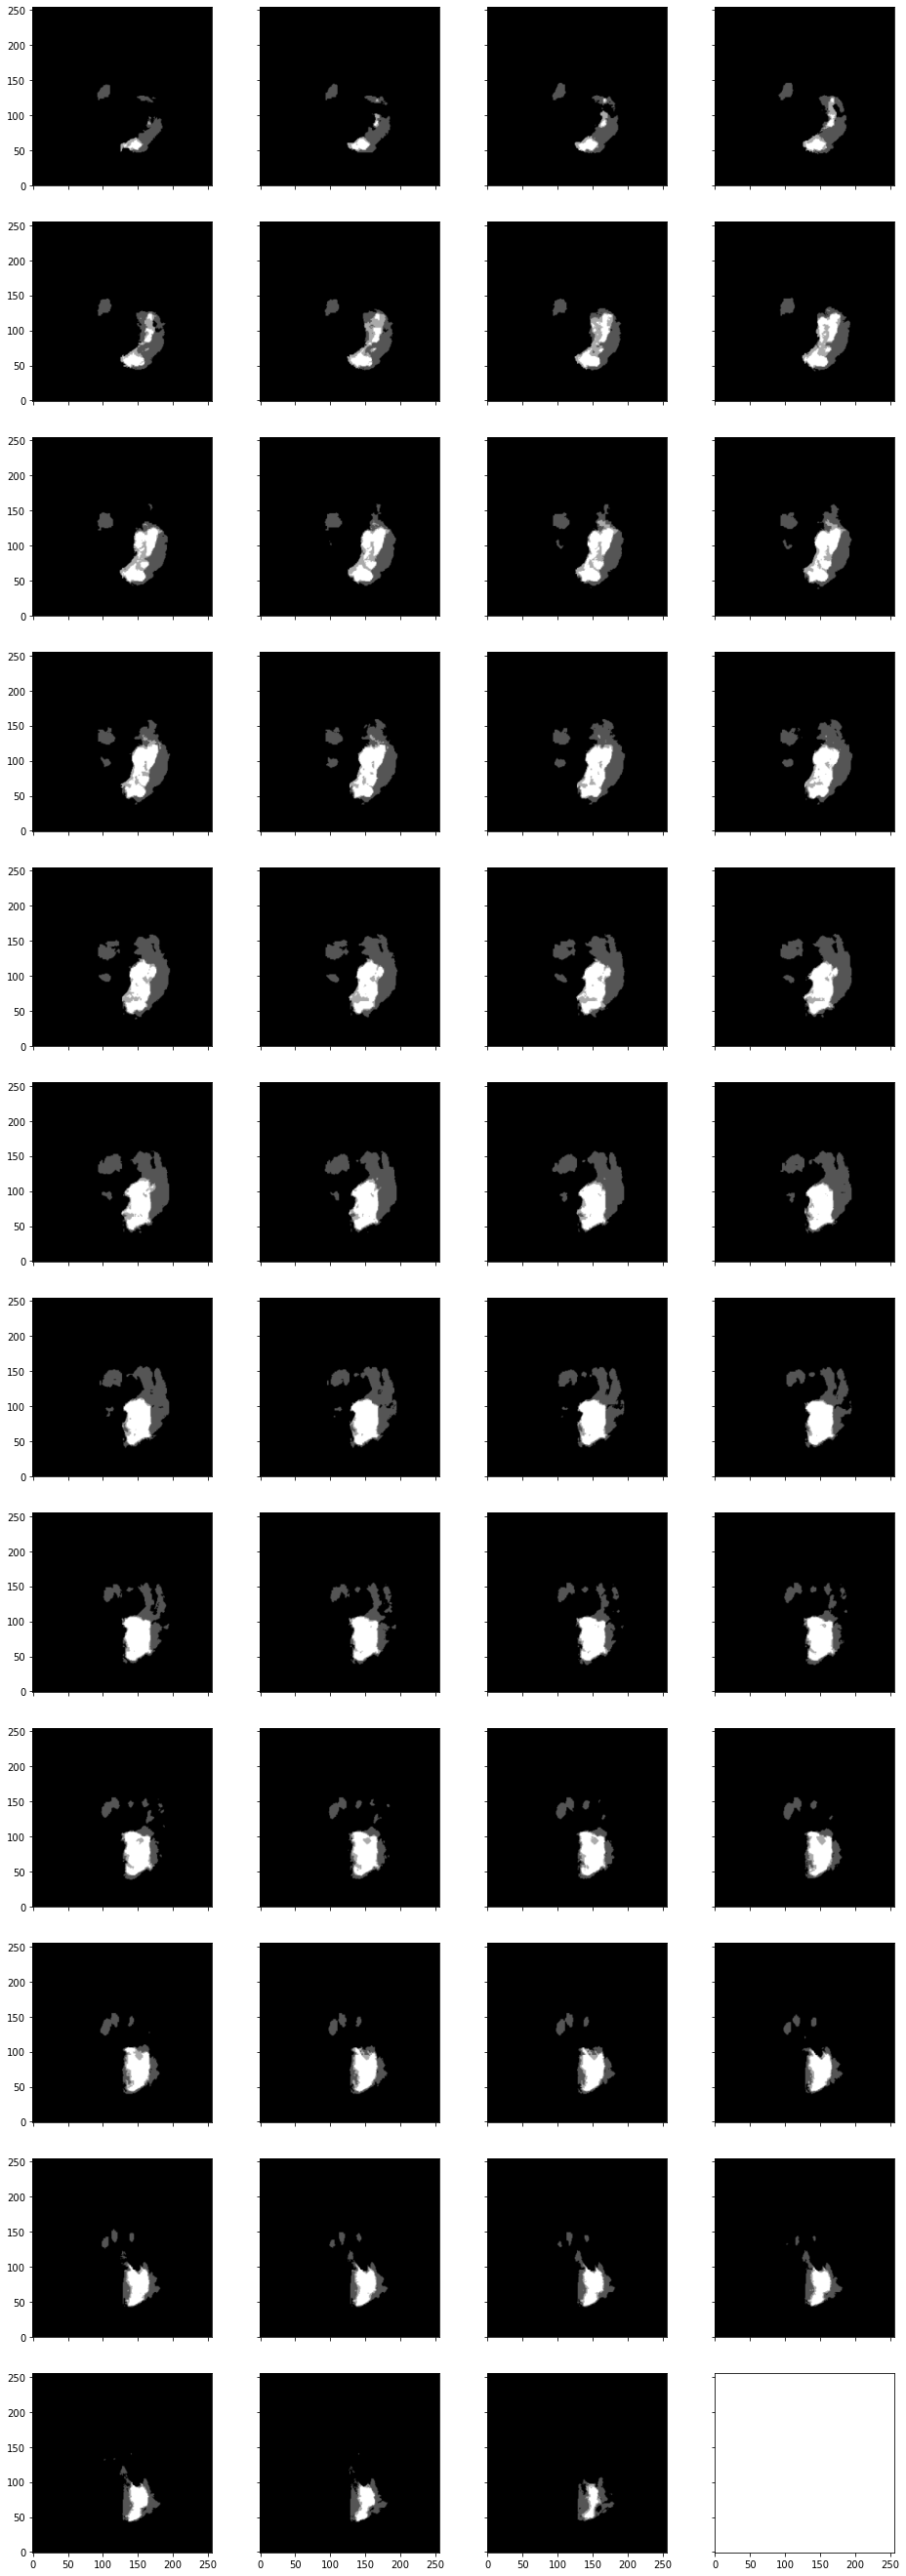

In [23]:
show_slices(slices_all)

## Edema
[To top](#top)

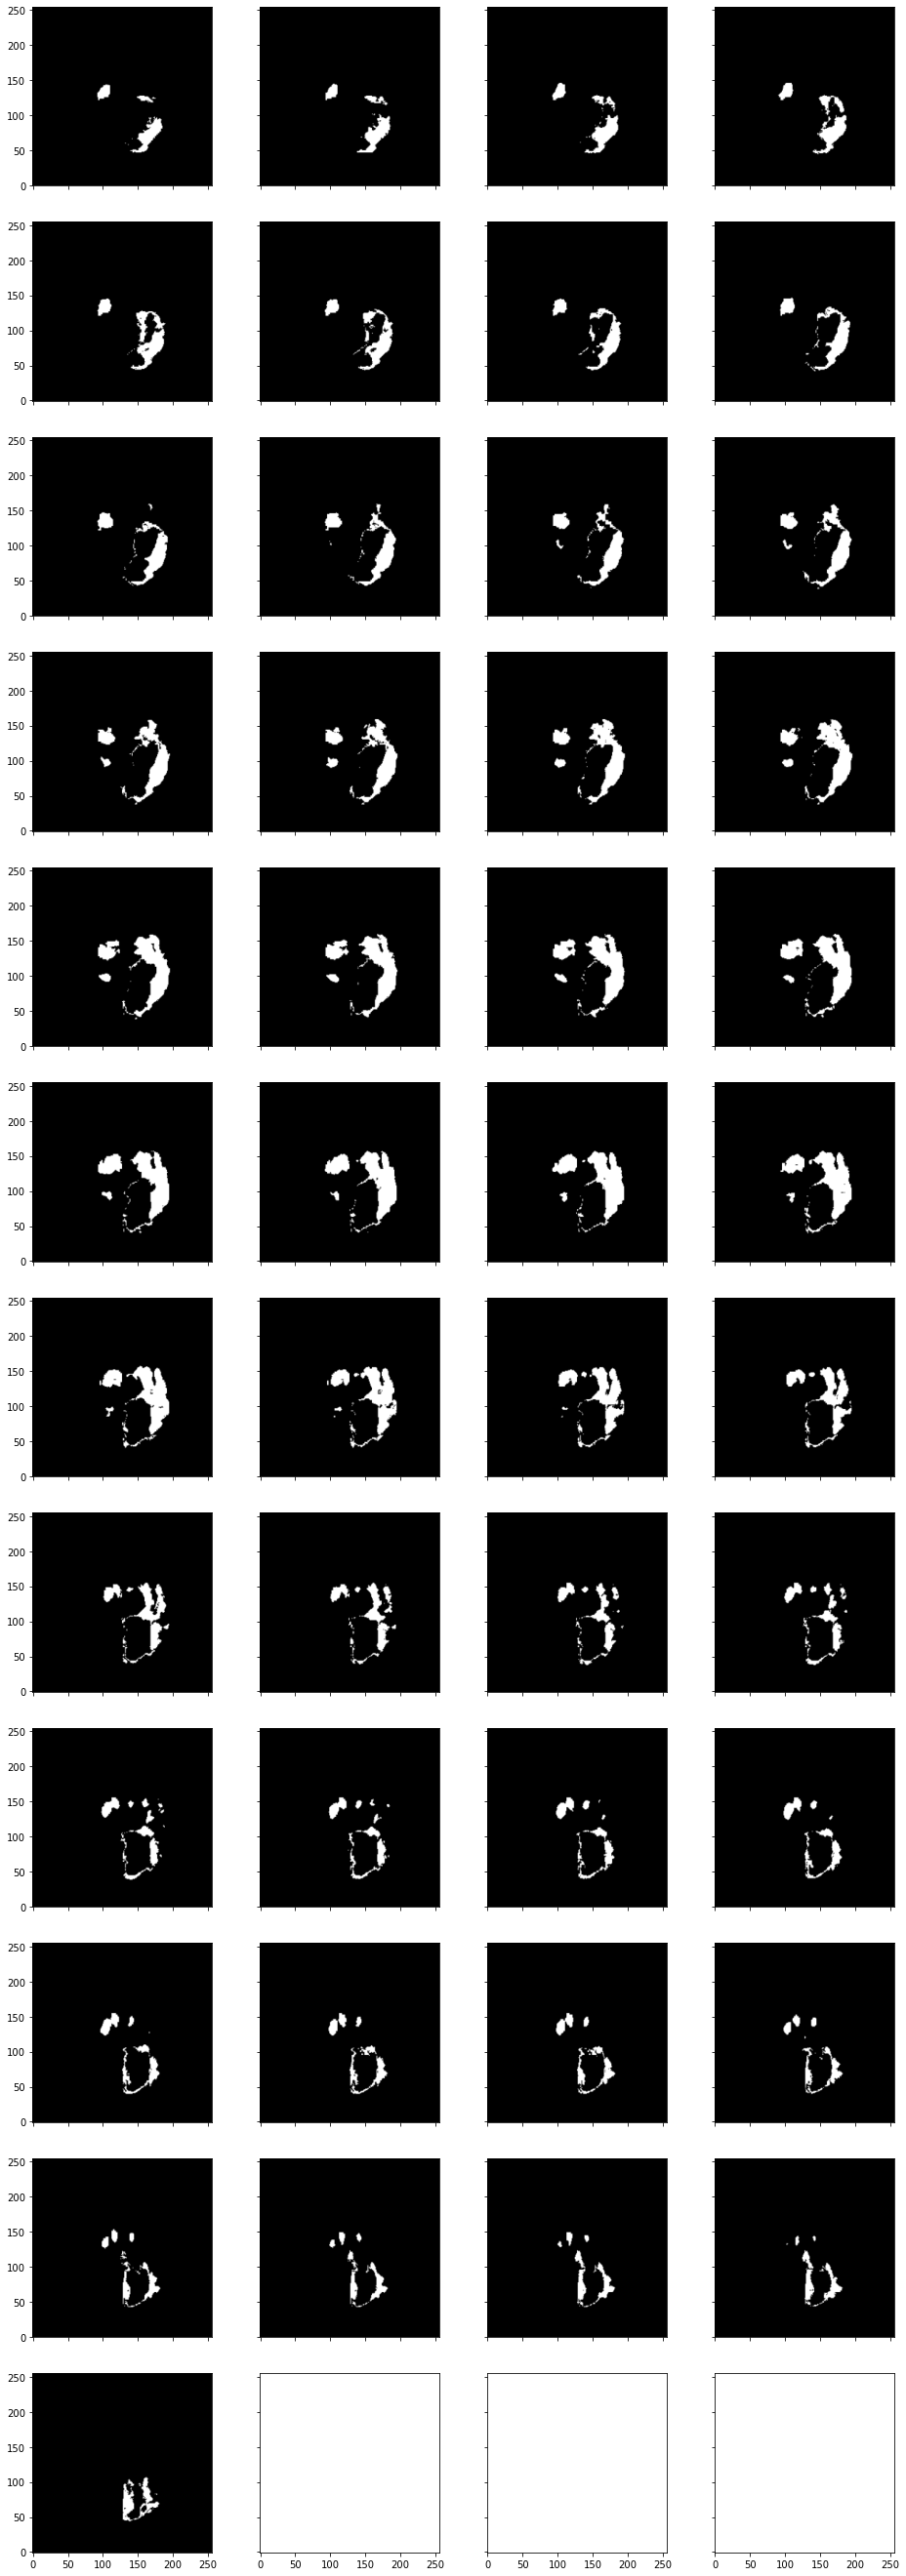

In [24]:
show_slices(slices_sep[1])

## Non-enhancing
[To top](#top)

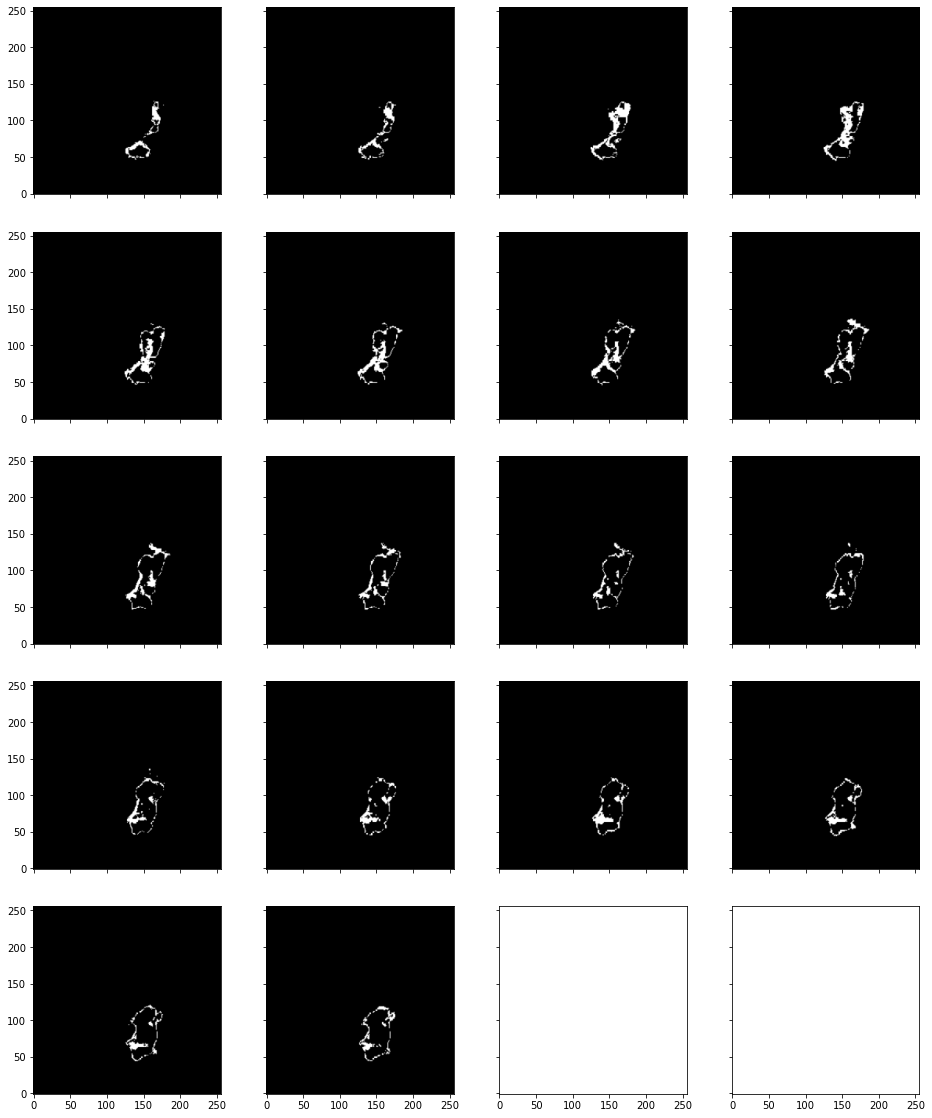

In [25]:
show_slices(slices_sep[2])

## Enhancing 
[To top](#top)

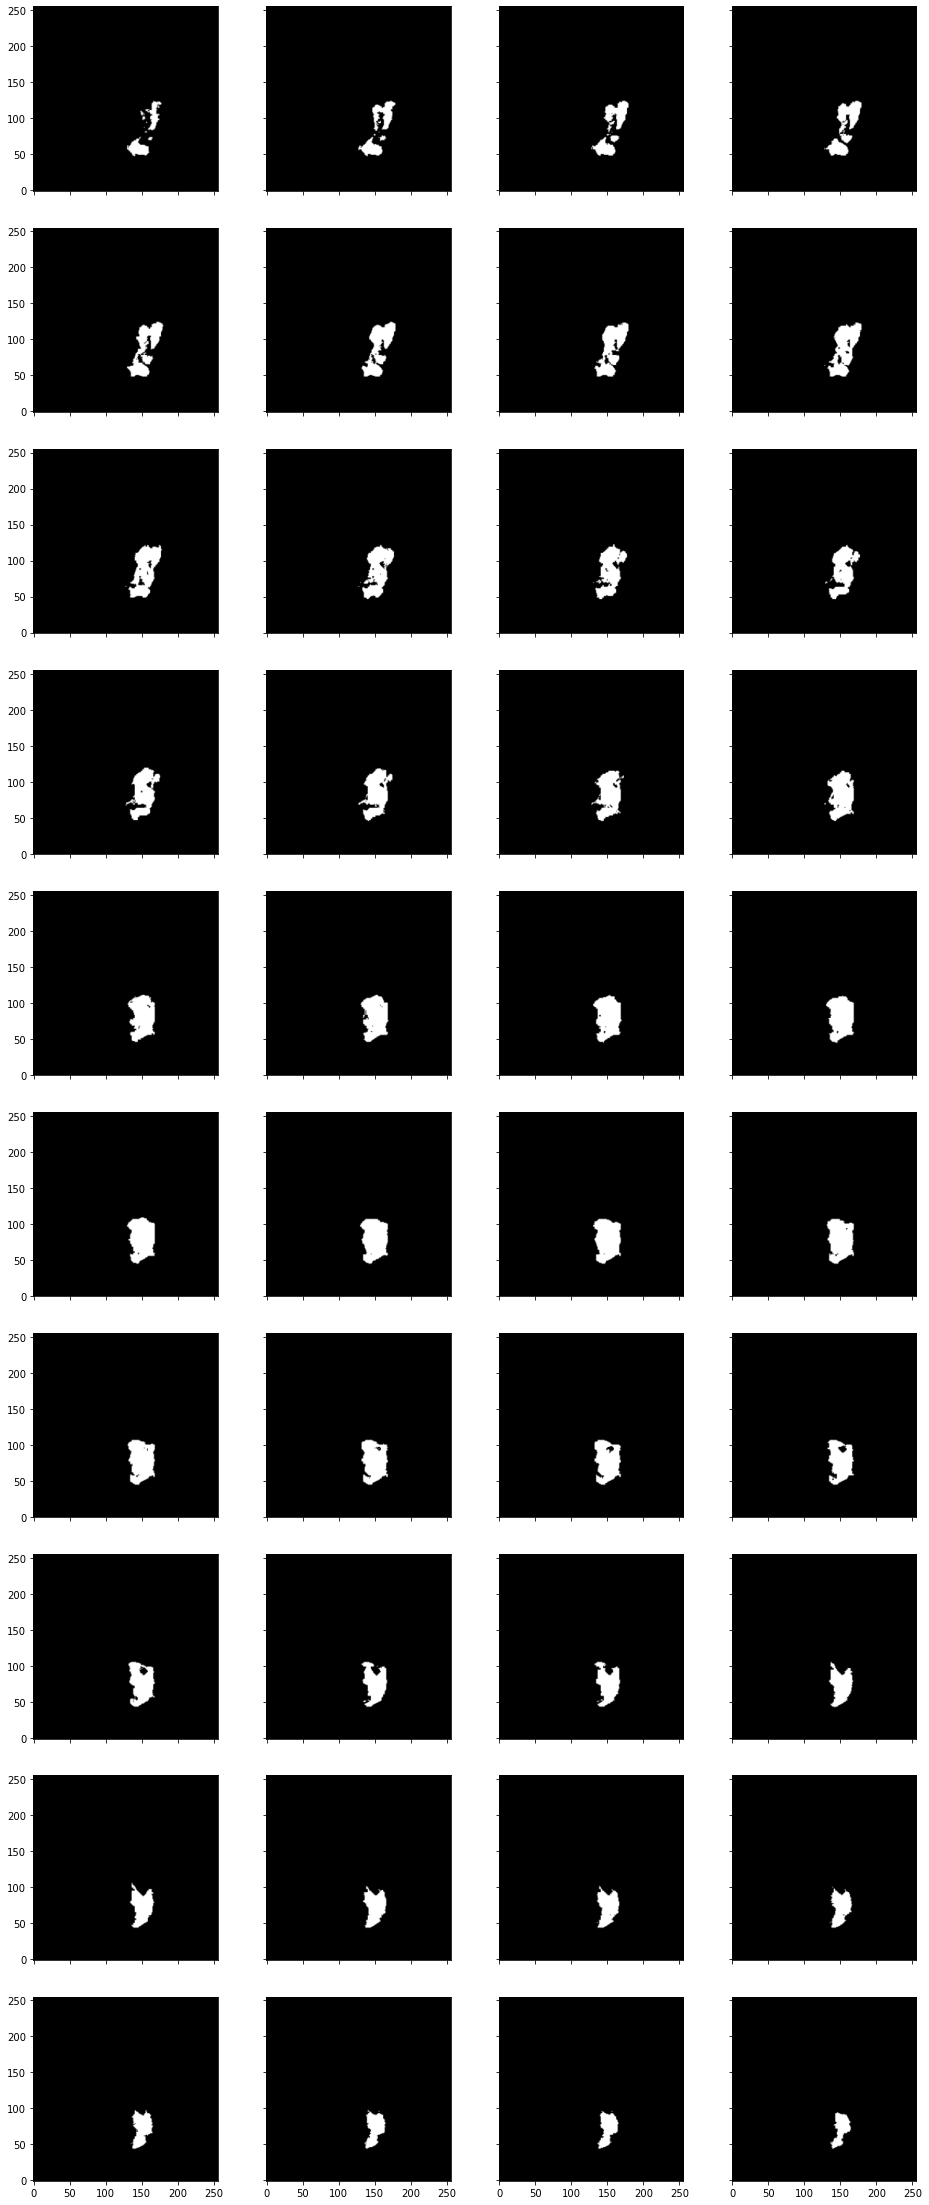

In [26]:
show_slices(slices_sep[3])

# Heart <a class="anchor" id="heart"></a>
[To top](#top)

In [27]:
mask = nib.load(paths["heart"]).get_fdata()
mask.shape

(320, 320, 120)

In [28]:
im = nib.load(im_paths["heart"]).get_fdata()
im.shape
print(im.min(), im.max())

0.0 1937.0


In [29]:
slices_sep, slices_all = sample_masks(paths["heart"], max_samples=None, 
                                      distinct_values=2, show = False,
                                     thresholds=[700])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

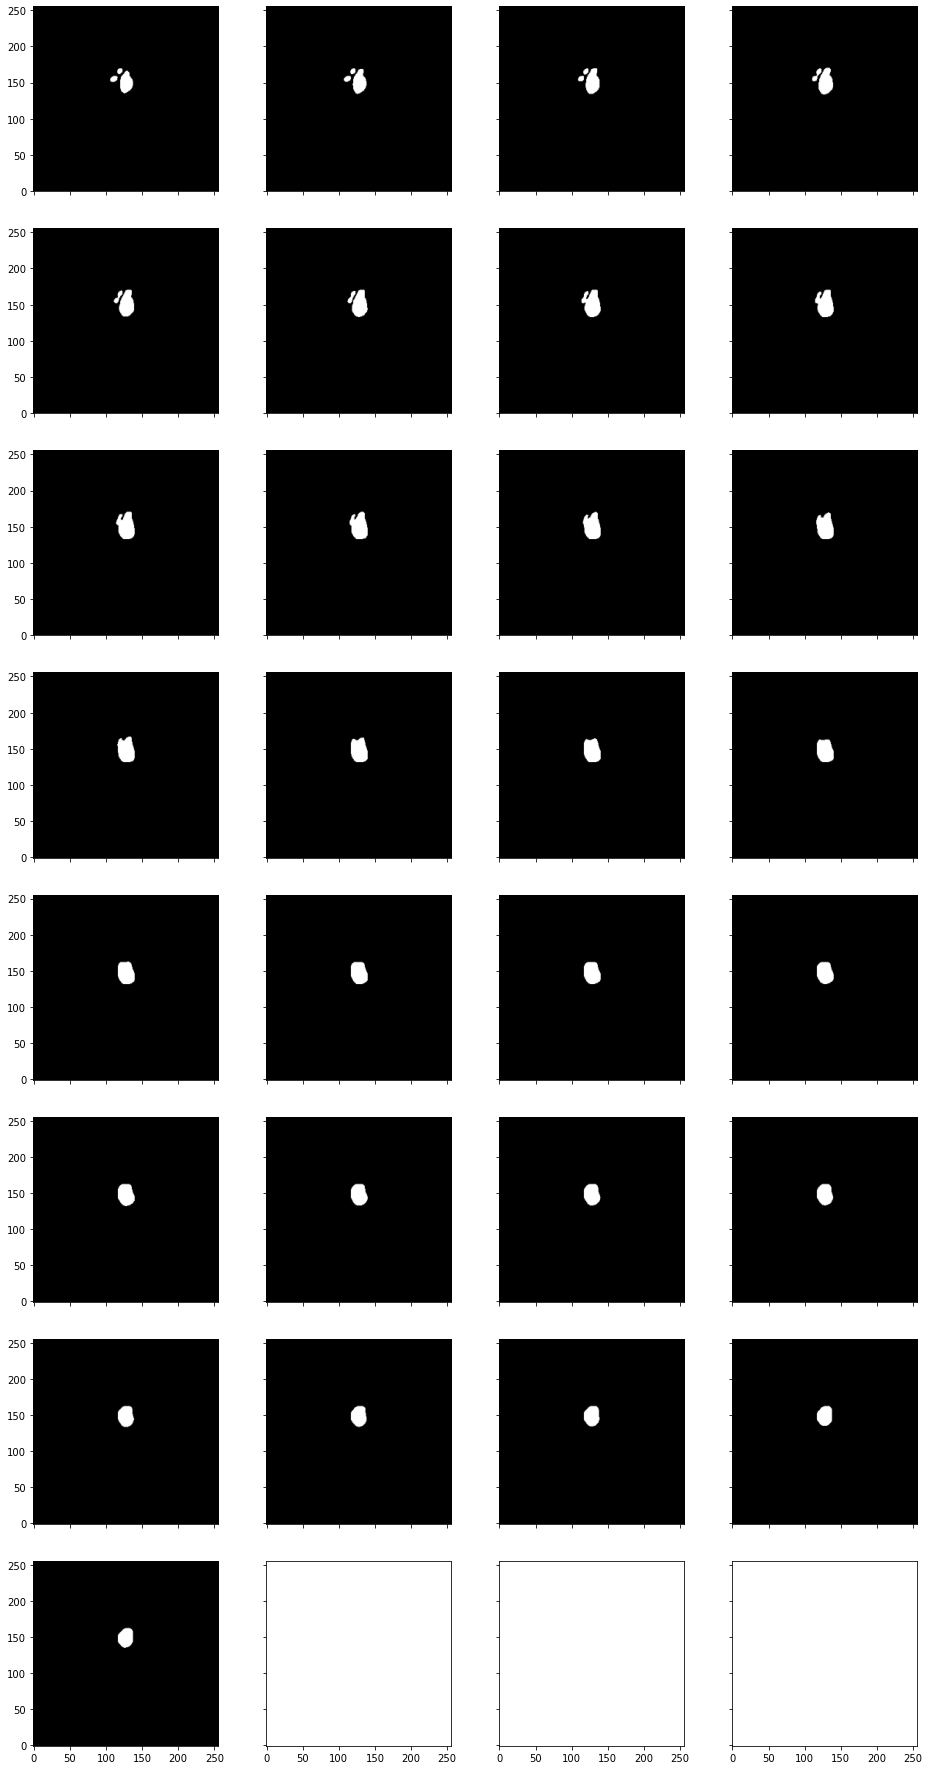

In [30]:
show_slices(slices_sep[1])

# Hippocampus <a class="anchor" id="hippocampus"></a>
[To top](#top)

In [31]:
mask = nib.load(paths["hippocampus"]).get_fdata()
mask.shape

(35, 53, 33)

In [32]:
im = nib.load(im_paths["hippocampus"]).get_fdata()
print(im.min(), im.max())

0.0 544567.0


In [33]:
# all slices from volume (images, not masks!)
images = [im[:,:,j] for j in range(im.shape[-1]) ]

In [34]:
slices_sep, slices_all = sample_masks(paths["hippocampus"], max_samples=None, 
                                      distinct_values=3, show = False,
                                     thresholds=[100,100])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

## All areas 
[To top](#top)

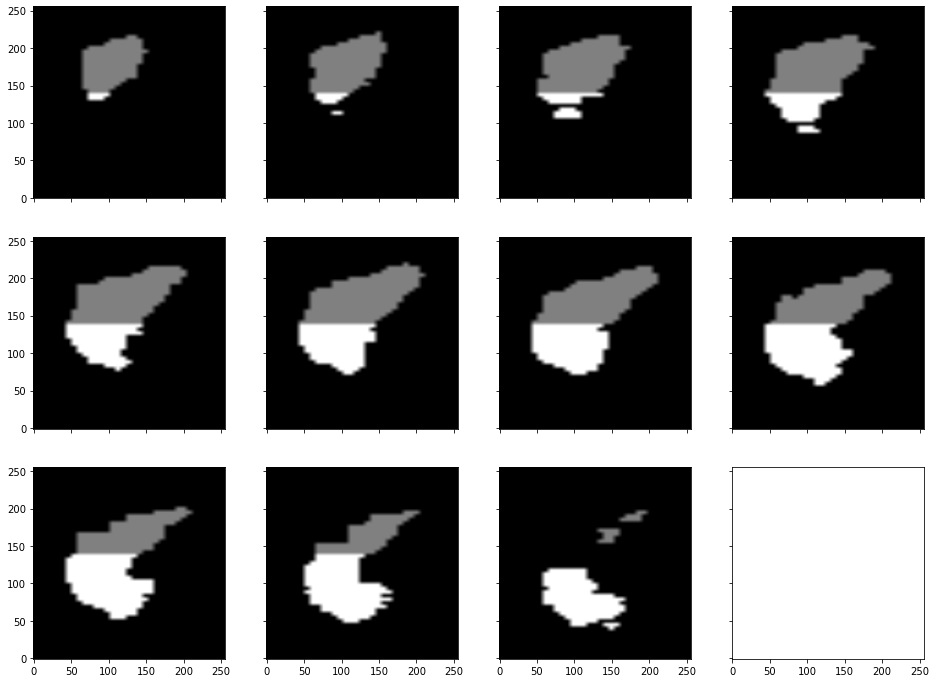

In [35]:
show_slices(slices_all)

## Anterior
[To top](#top)

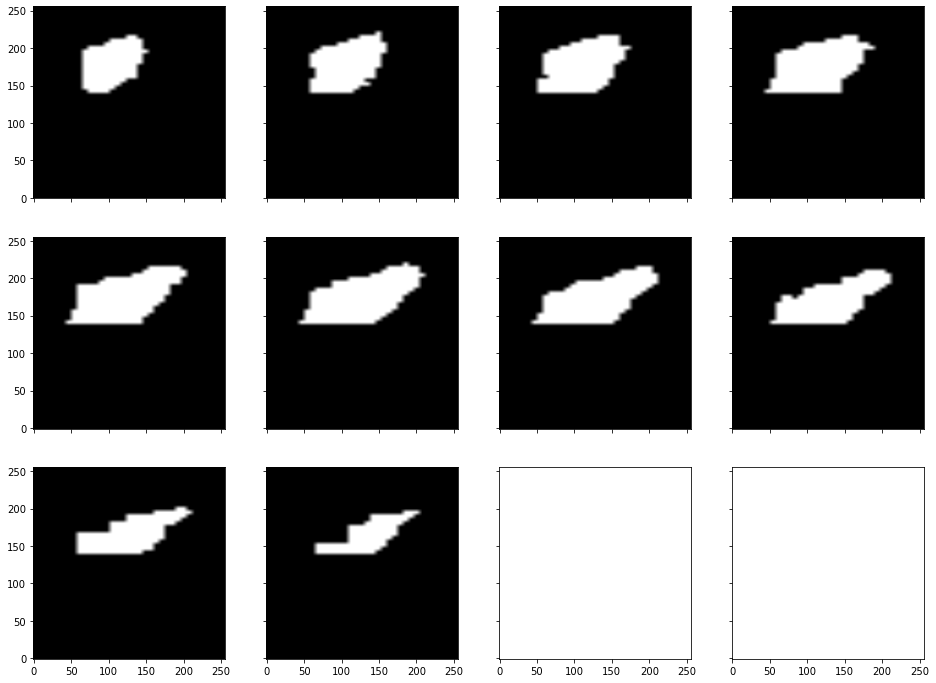

In [36]:
show_slices(slices_sep[1])

## Posterior
[To top](#top)

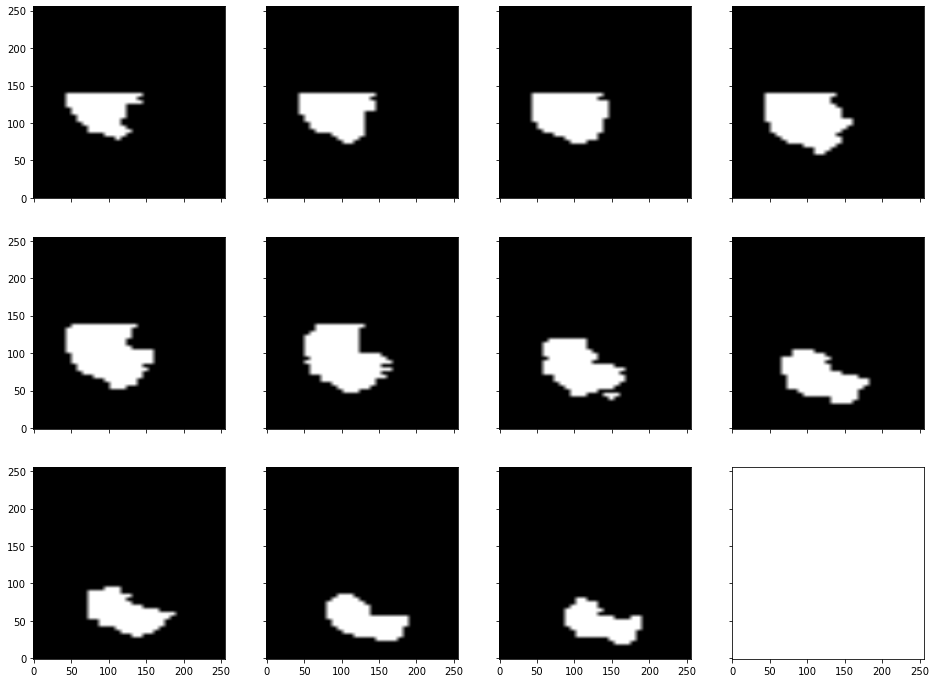

In [37]:
show_slices(slices_sep[2])

# Prostate <a class="anchor" id="prostate"></a>
[To top](#top)

In [38]:
def normalize(slice_, min_=-1000, max_=400):
    slice_ = (slice_- min_)/(max_-min_)
    slice_[slice_>1] = 1
    slice_[slice_<0] = 0
    return slice_

In [39]:
mask = nib.load(paths["prostate"]).get_fdata()
mask.shape

(320, 320, 20)

In [40]:
im_paths["prostate"] = Path().cwd().parent / "Task05_Prostate" / "imagesTr" / "prostate_24.nii.gz"

In [41]:
im = nib.load(im_paths["prostate"]).get_fdata()
t2 = im[:,:,:,0] 
print(t2.min(), t2.max())
print(t2.shape)

0.0 1574.0
(320, 320, 20)


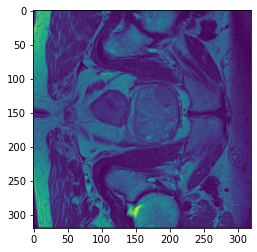

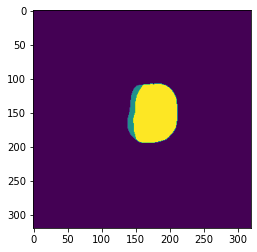

In [43]:
ind = 7
sample_prostate = t2[:,:,ind]
sample_prostate_mask = mask[:,:,ind]
plt.imshow(sample_prostate)
plt.pause(0.05)
plt.imshow(sample_prostate_mask)

In [39]:
slices_sep, slices_all = sample_masks(paths["prostate"], max_samples=None, 
                                      distinct_values=3, show = False,
                                     thresholds=[300,600])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

## All areas
[To top](#top)

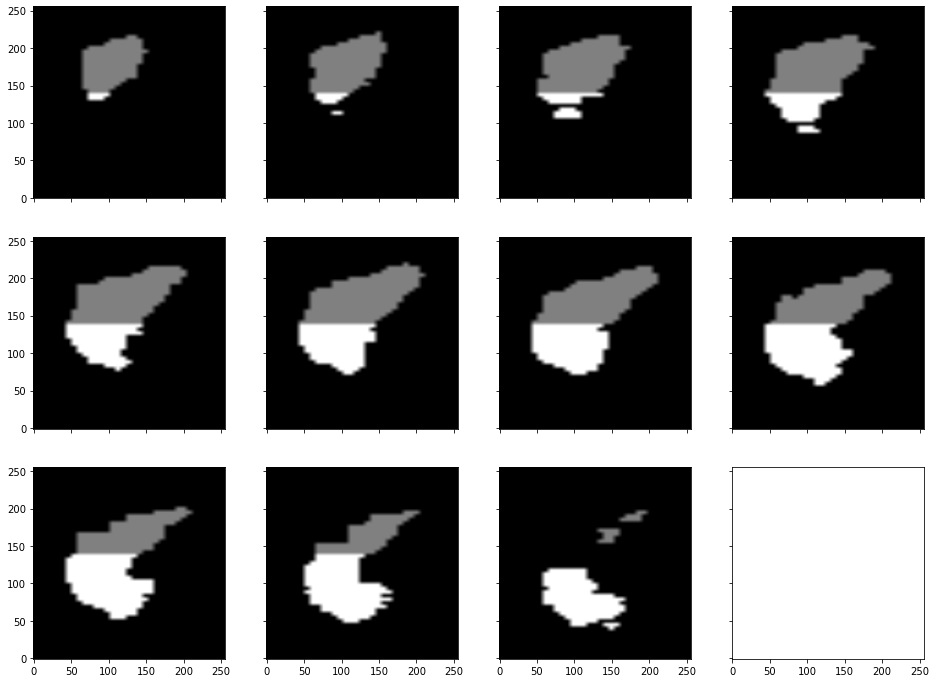

In [44]:
show_slices(slices_all)

## Peripheral
[To top](#top)

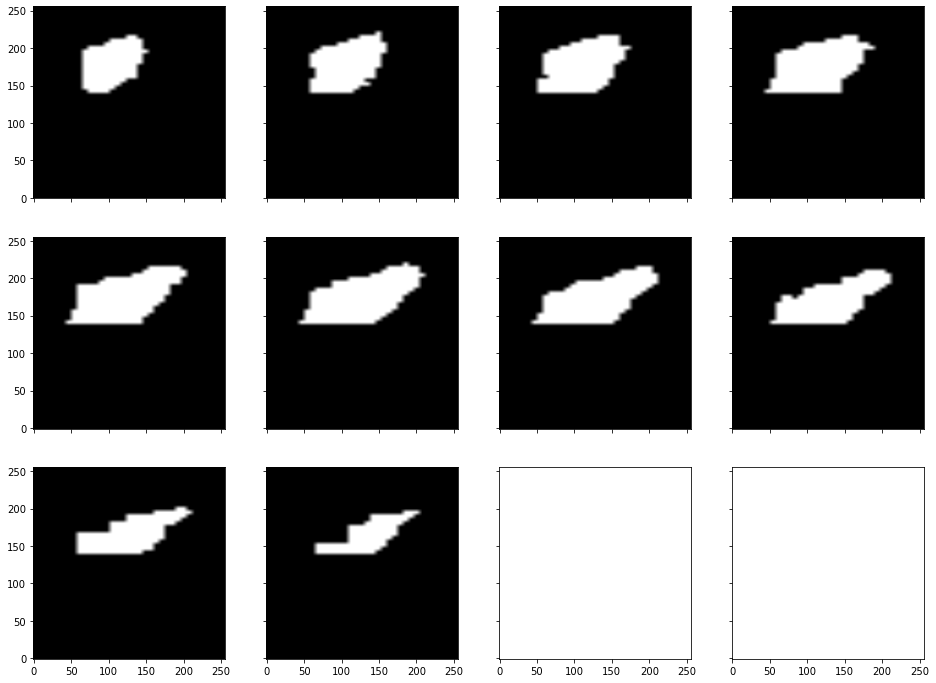

In [45]:
show_slices(slices_sep[1])

## Transitional
[To top](#top)

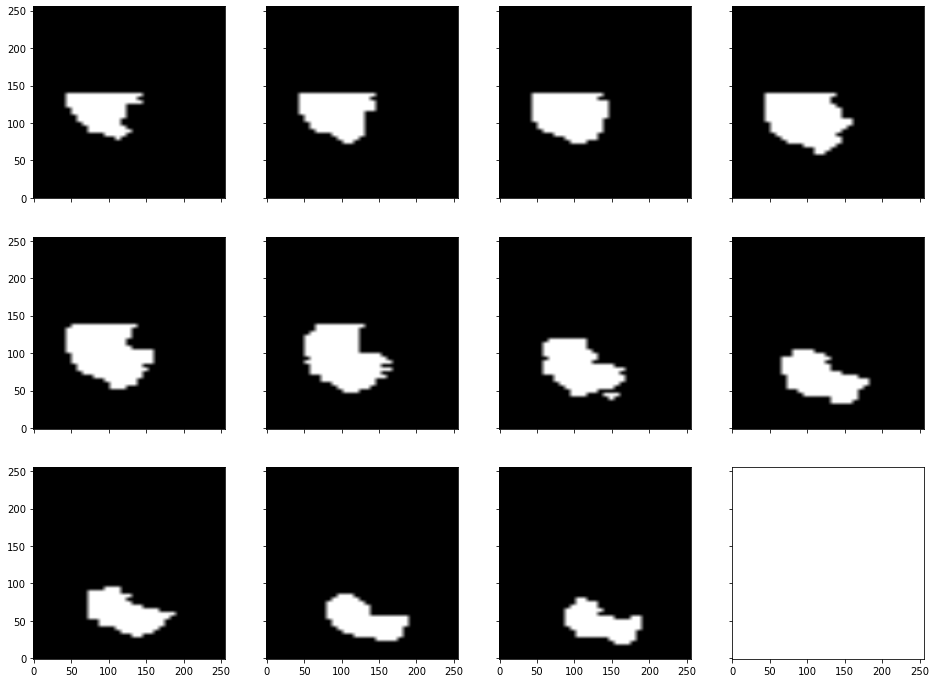

In [46]:
show_slices(slices_sep[2])

# Lungs <a class="anchor" id="lung"></a>
[To top](#top)

In [47]:
mask = nib.load(paths["lung"]).get_fdata()
mask.shape

(512, 512, 304)

In [48]:
im = nib.load(im_paths["lung"]).get_fdata()
print(im.min(), im.max())

-1024.0 3071.0


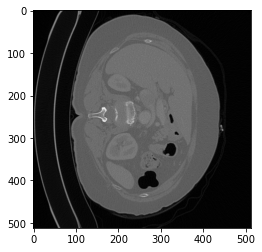

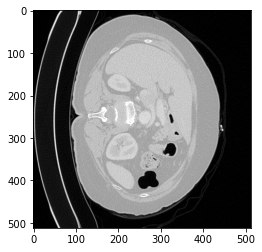

In [49]:
one_slice = im[:,:,1]
outp = normalize(one_slice)
plt.imshow(one_slice, cmap="gray")
plt.pause(0.05)
plt.imshow(outp, cmap="gray")

In [104]:
import pylab
import  matplotlib.cm        as      cm

In [105]:
pylab.imsave("test_im.png", one_slice, format="png", cmap = cm.Greys_r)

In [50]:
slices_sep, slices_all = sample_masks(paths["lung"], max_samples=None, 
                                      distinct_values=2, show = False,
                                     thresholds=[200])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

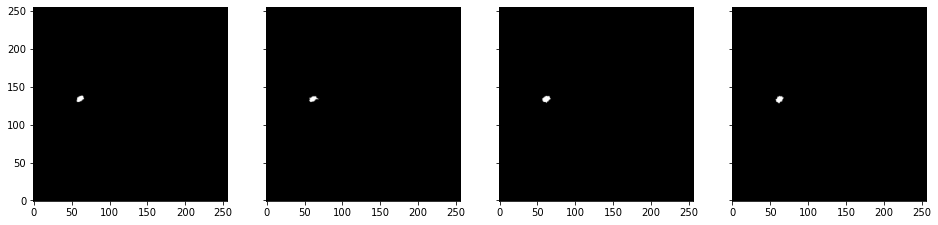

In [51]:
show_slices(slices_sep[1])

## Investigate what's going on with Lungs
[To top](#top)

In [52]:
import nibabel as nib
import numpy as np

In [53]:
path_to_lungs = Path.cwd().parent / "Task06_Lung" / 'labelsTr' 
all_lung_masks = list(path_to_lungs.glob("**/*.nii.gz"))
lung_masks = []
for path in all_lung_masks:
    if not str(path).split("\\")[-1].startswith("._"):
        lung_masks.append(path)

In [54]:
len(lung_masks)

63

In [55]:
VOLUME_NUMBER = 50

In [56]:
im = nib.load(lung_masks[VOLUME_NUMBER]).get_fdata()
im.shape

(512, 512, 369)

In [57]:
im = nib.load(lung_masks[VOLUME_NUMBER]).get_fdata()
pixels = []
slices = []
for i in range(im.shape[-1]):
    sl = im[:,:,i]
    pixels.append(sl.sum())
    if sl.sum() > 1000:
        slices.append(sl)
len(slices)
len(slices), np.array(pixels).max()

(34, 2785.0)

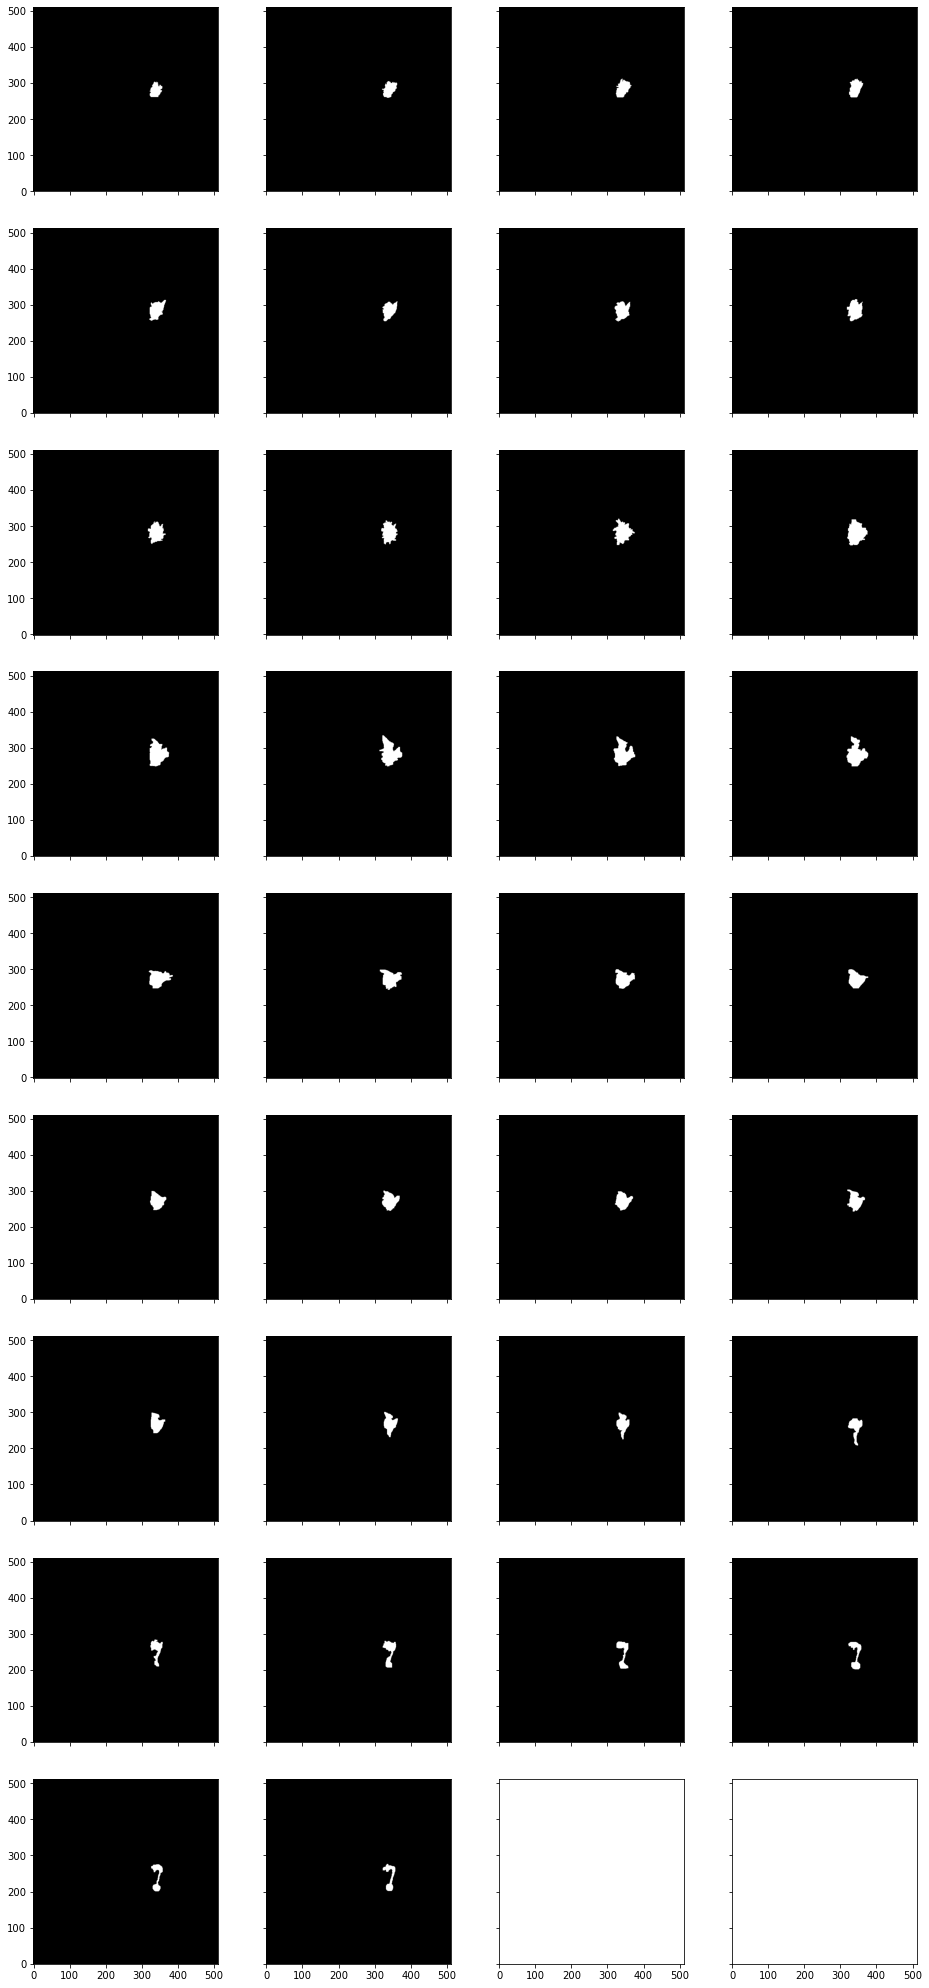

In [58]:
show_slices(slices)

### Conclusion 
If cancer area is small, the mask, of course will be very small. If we exclude them, masks will be better. However, from the medial point of view, we are interested exactly in these small regions.

# Pancreas <a class="anchor" id="pancreas"></a>
[To top](#top)

In [59]:
mask = nib.load(paths["pancreas"]).get_fdata()
mask.shape

(512, 512, 87)

In [60]:
im = nib.load(im_paths["pancreas"]).get_fdata()
print(im.min(), im.max())

-1024.0 2209.0


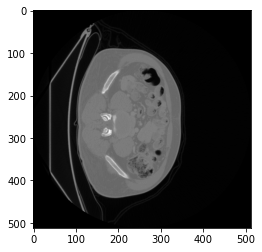

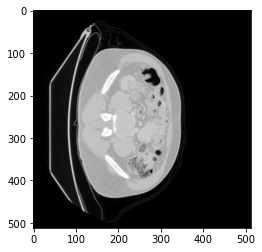

In [61]:
one_slice = im[:,:,1]
outp = normalize(one_slice)
plt.imshow(one_slice, cmap="gray")
plt.pause(0.05)
plt.imshow(outp, cmap="gray")

In [62]:
slices_sep, slices_all = sample_masks(paths["pancreas"], max_samples=None, 
                                      distinct_values=3, show = False,
                                     thresholds=[200,200])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

## All regions
[To top](#top)

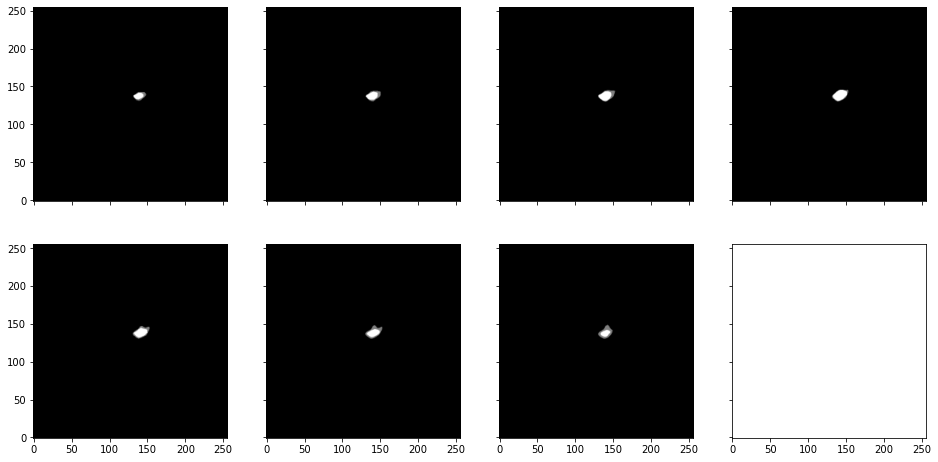

In [63]:
show_slices(slices_all)

## Pancreas organ
[To top](#top)

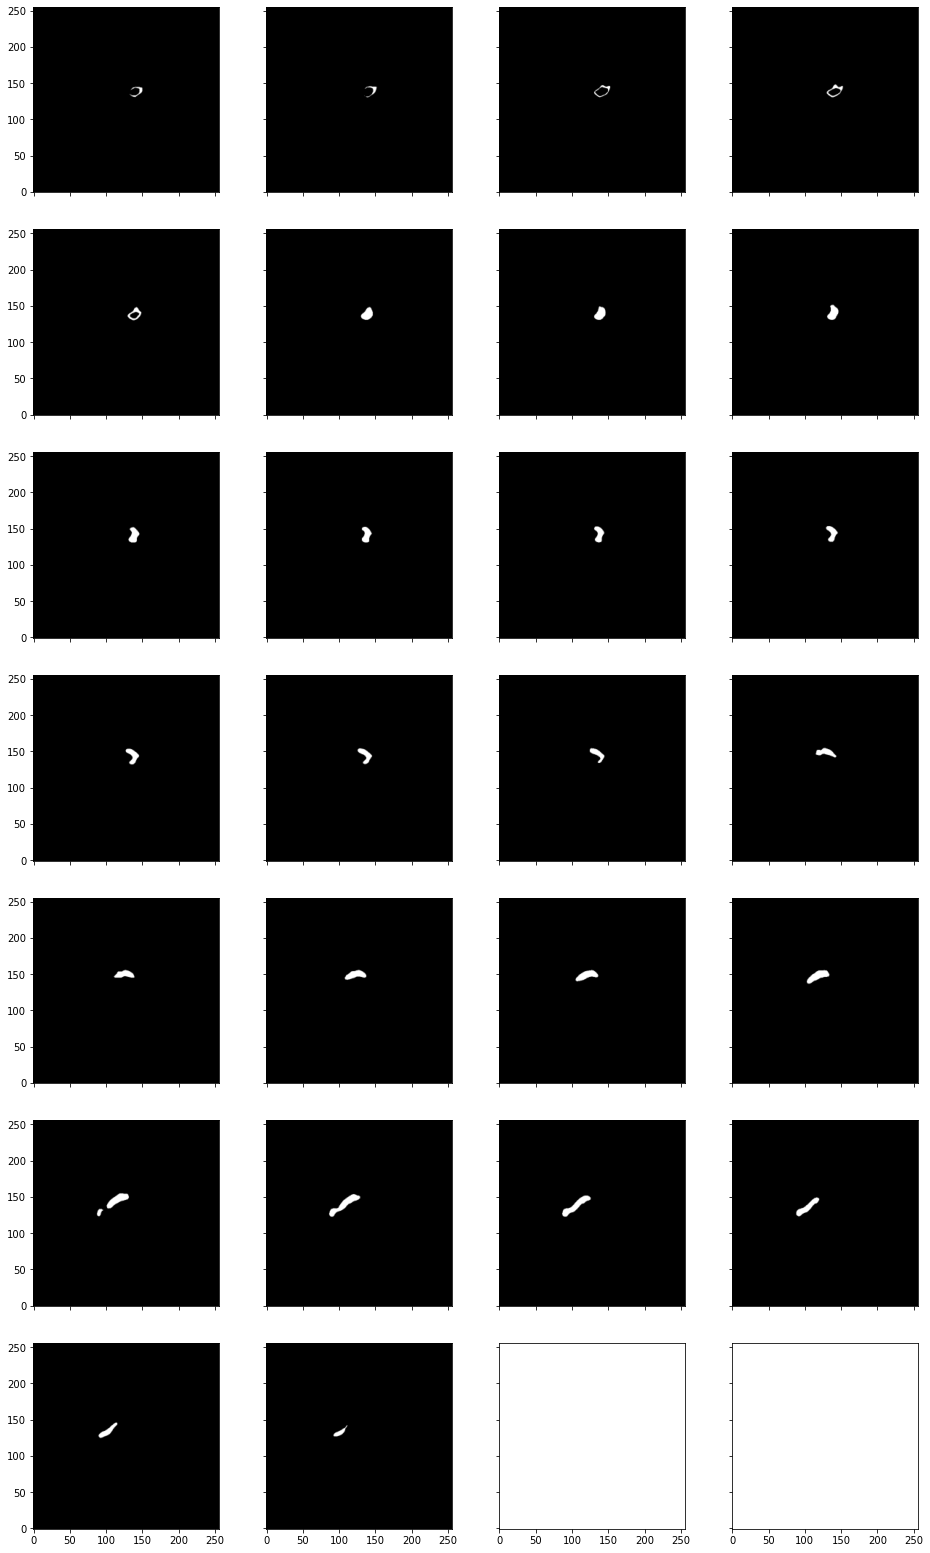

In [64]:
show_slices(slices_sep[1])

## Pancreas Cancer
[To top](#top)

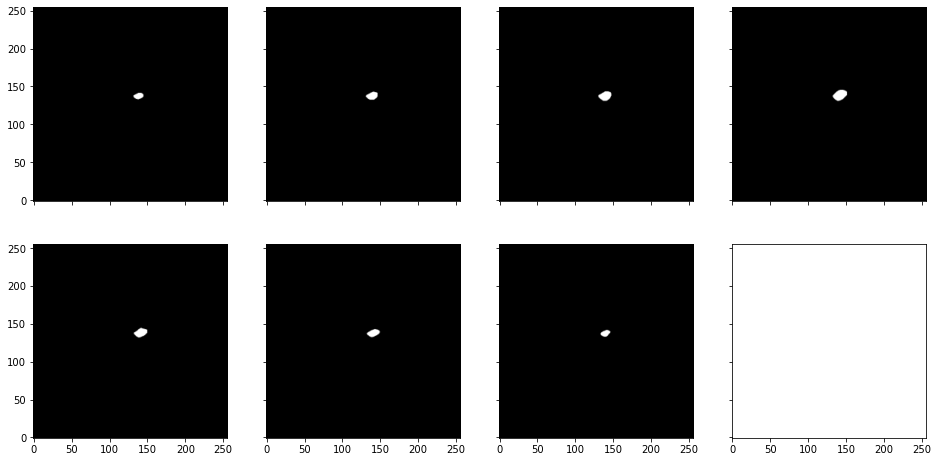

In [65]:
show_slices(slices_sep[2])

### Investigate what's going on 

In [66]:
path_to_lungs = Path.cwd().parent / "Task07_Pancreas" / 'labelsTr' 
all_pancreas_masks = list(path_to_lungs.glob("**/*.nii.gz"))
pancreas_masks = []
for path in all_pancreas_masks:
    if not str(path).split("\\")[-1].startswith("._"):
        pancreas_masks.append(path)

In [67]:
VOLUME_NUMBER=1

In [68]:
im = nib.load(pancreas_masks[VOLUME_NUMBER]).get_fdata()
pixels = []
slices = []
n_ones = []
n_twos = []
cancer = []
for i in range(im.shape[-1]):
    sl = im[:,:,i]
    pixels.append(sl.sum())
    if sl.sum() > 1000:
        slices.append(sl)
        n_ones.append((sl == 1).sum())
        n_twos.append((sl == 2).sum())
    if (sl==2).sum() > 1000: 
        print((sl==2).sum())
        cancer.append(sl)

1140
1454
1760
2123
2733
2875
2704
2552
2223
2128
2213
2060
1804


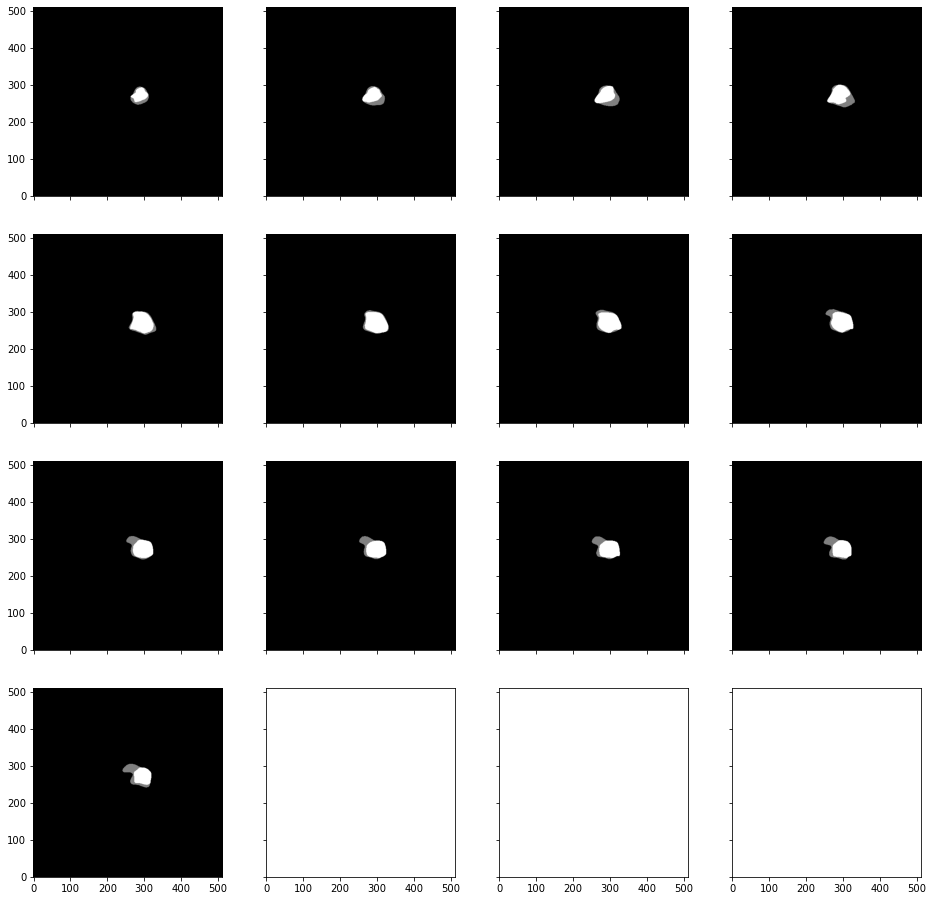

In [69]:
show_slices(cancer)

**Conclusion** 

If cancer is present significantly, then pancreas is barely seen, it's often shadowed by cancer, that's why pictures look like that. 
Note: The script prints the slice if both objects are present and the threshold for at least one of them is passed.

# Hepatic Vessel <a class="anchor" id="vessel"></a>
[To top](#top)

[Research on hepatic vessel](https://www.researchgate.net/publication/46159571_Automated_segmentation_of_hepatic_vessels_in_non-contrast_X-ray_CT_images)

![How they look in real](https://www.researchgate.net/profile/Hiroshi_Fujita2/publication/46159571/figure/fig2/AS:601682731864112@1520463750639/D-view-of-the-liver-and-hepatic-vessel-tree-a-Volume-rendering-of-contrast-enhanced-CT_Q320.jpg)

In [70]:
mask = nib.load(paths["vessel"]).get_fdata()
mask.shape

(512, 512, 49)

In [71]:
im = nib.load(im_paths["vessel"]).get_fdata().astype(np.float32).squeeze()
print(im.min(), im.max())

-1024.0 1289.0


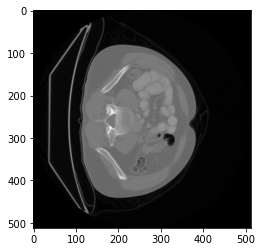

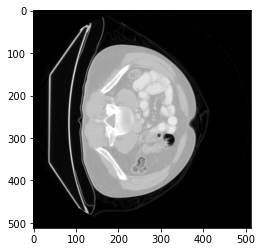

In [72]:
one_slice = im[:,:,1]
outp = normalize(one_slice)
plt.imshow(one_slice, cmap="gray")
plt.pause(0.05)
plt.imshow(outp, cmap="gray")

In [73]:
from skimage.transform import resize

In [74]:
image_resized = resize(outp, (256,256))

In [75]:
from skimage.io import imsave

In [76]:
imsave("test.tiff", outp)

In [77]:
from PIL import Image

In [79]:
slices_sep, slices_all = sample_masks(paths["vessel"], max_samples=None, 
                                      distinct_values=3, show = False,
                                     thresholds=[100,0])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

## All regions
[To top](#top)

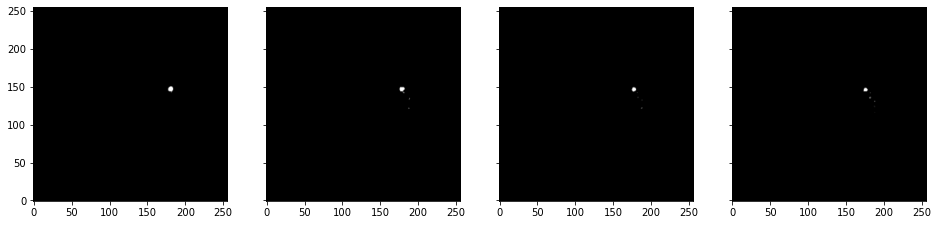

In [80]:
show_slices(slices_all)

## Vessel
[To top](#top)

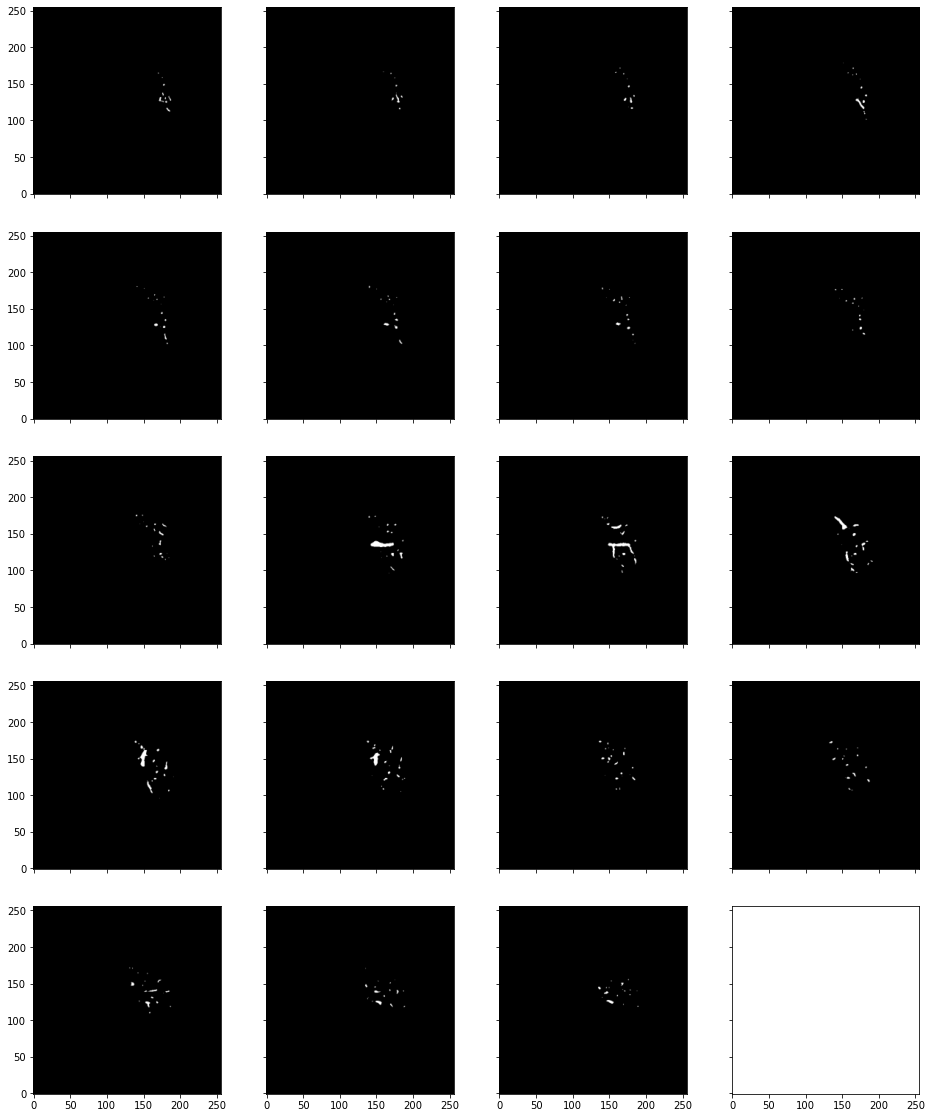

In [81]:
show_slices(slices_sep[1])

## Tumour
[To top](#top)

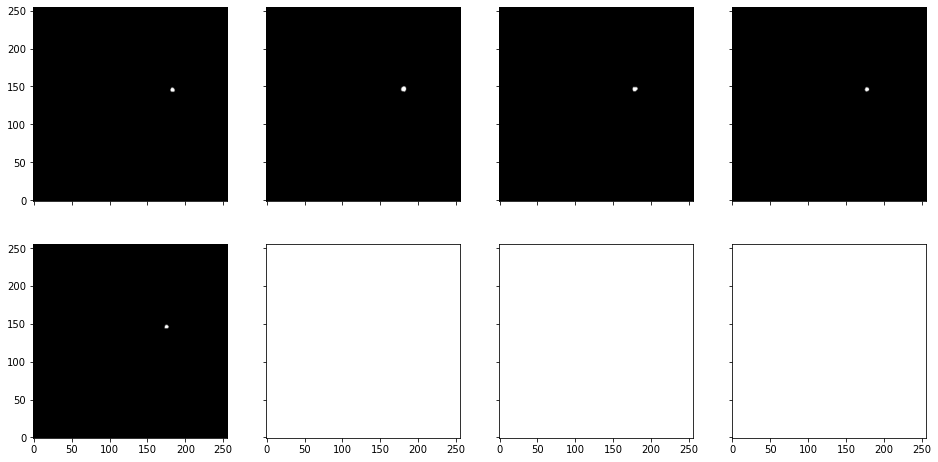

In [82]:
show_slices(slices_sep[2])

## Investigate what's going on 
[To top](#top)

In [83]:
path_to_vessels = Path.cwd().parent / "Task08_HepaticVessel" / 'labelsTr' 
all_vessel_masks = list(path_to_vessels.glob("**/*.nii.gz"))
vessel_masks = []
for path in all_vessel_masks:
    if not str(path).split("\\")[-1].startswith("._"):
        vessel_masks.append(path)

In [84]:
VOLUME_NUMBER=30

In [85]:
im = nib.load(vessel_masks[VOLUME_NUMBER]).get_fdata()
pixels = []
slices = []
cancer = []
vessel = []
for i in range(im.shape[-1]):
    sl = im[:,:,i]
    pixels.append(sl.sum())
    if sl.sum() > 0:
        slices.append(sl)
    if (sl==2).sum() > 1000: 
        sl_ = sl.copy()
        sl_[sl != 2] = 0
        cancer.append(sl_)
    if (sl==1).sum() > 1000:
        sl_ = sl.copy()
        sl_[sl != 1] = 0
        vessel.append(sl_) 

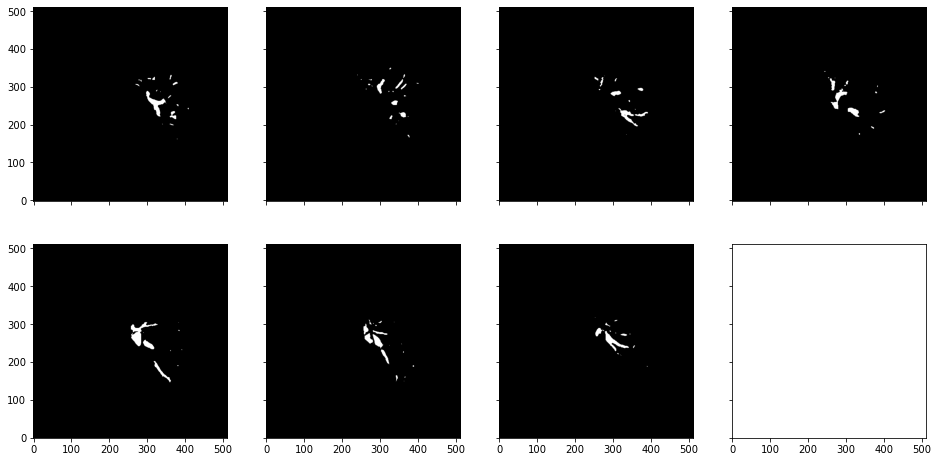

In [86]:
show_slices(vessel)

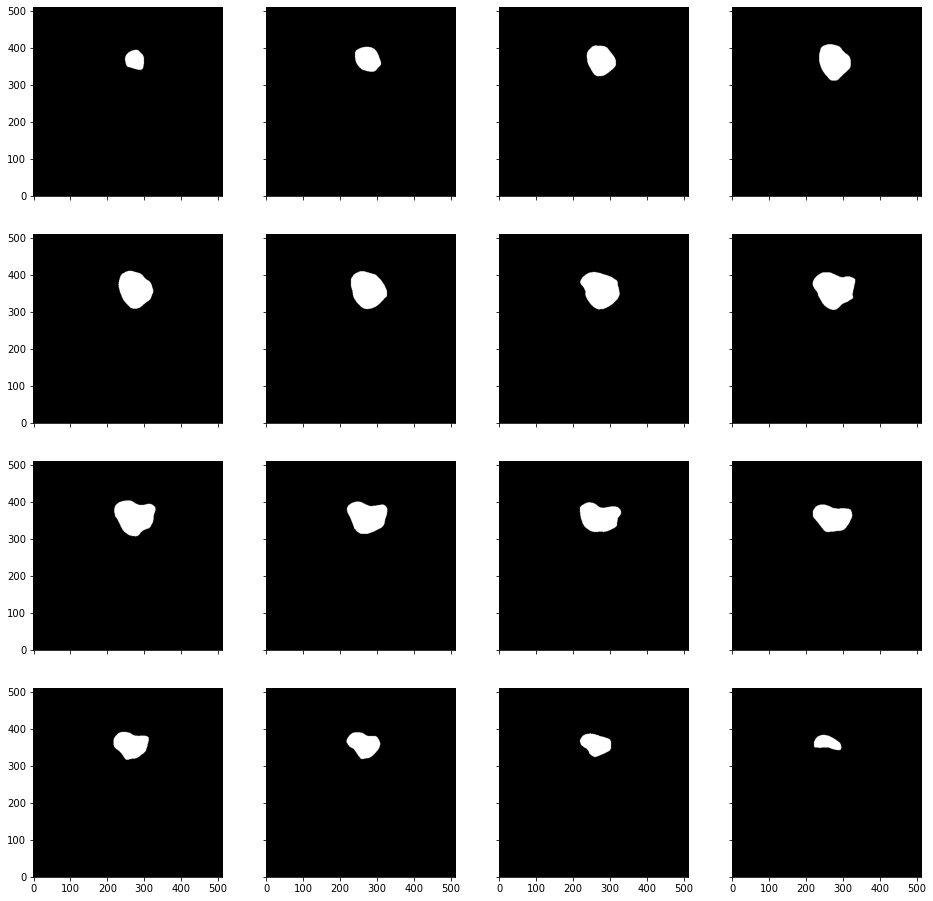

In [87]:
show_slices(cancer)

**Conclusion**

Maybe it doesn't make much sense to do hepatic vessels in 2D. Look like random spots. However, it worked with the cells, so might work as well. 

# Spleen <a class="anchor" id="spleen"></a>
[To top](#top)

In [88]:
mask = nib.load(paths["spleen"]).get_fdata()
mask.shape

(512, 512, 55)

In [89]:
im = nib.load(im_paths["spleen"]).get_fdata()
print(im.min(), im.max())

-1024.0 3072.0


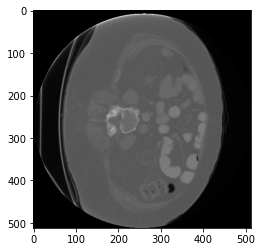

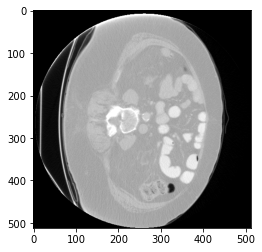

In [90]:
one_slice = im[:,:,1]
outp = normalize(one_slice)
plt.imshow(one_slice, cmap="gray")
plt.pause(0.05)
plt.imshow(outp, cmap="gray")

In [91]:
slices_sep, slices_all = sample_masks(paths["spleen"], max_samples=None, 
                                      distinct_values=2, show = False,
                                     thresholds=[600])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

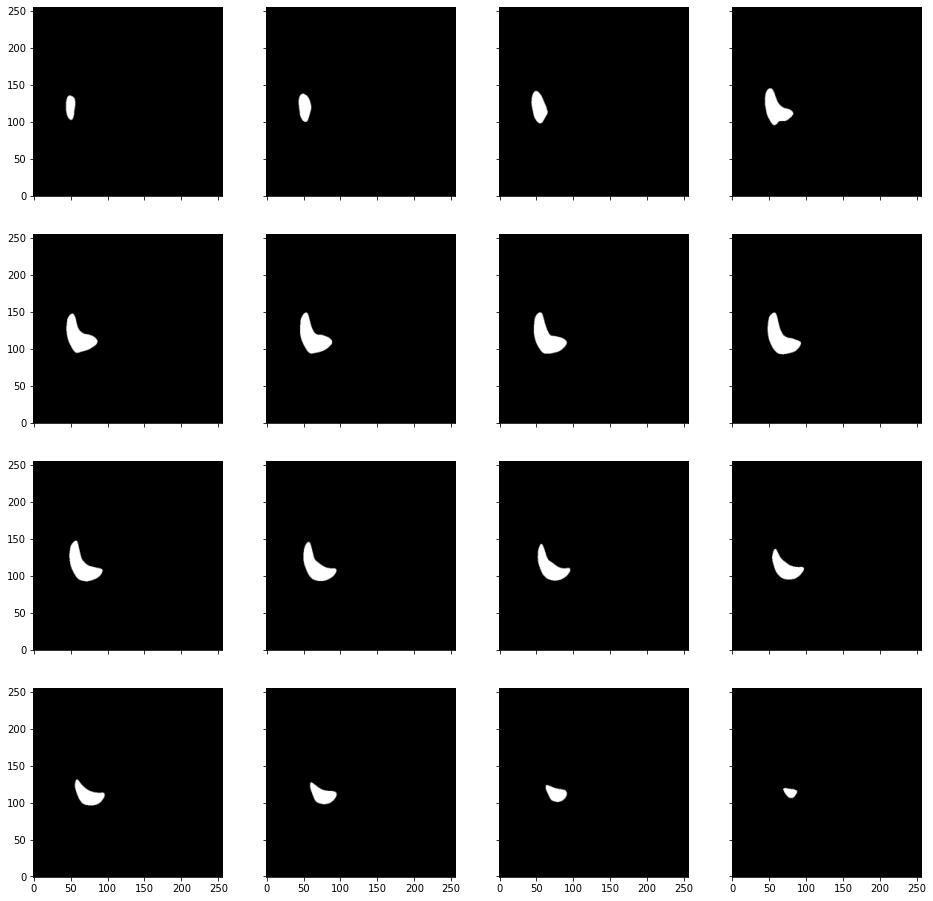

In [92]:
show_slices(slices_sep[1])

# Colon <a class="anchor" id="colon"></a>
[To top](#top)

In [93]:
mask = nib.load(paths["colon"]).get_fdata()
mask.shape

(512, 512, 60)

In [94]:
im = nib.load(im_paths["colon"]).get_fdata()
print(im.min(), im.max())

-1024.0 3072.0


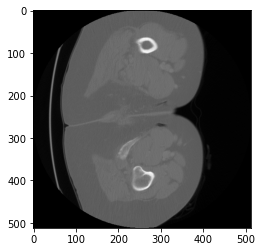

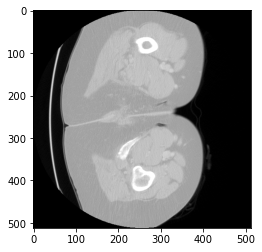

In [95]:
one_slice = im[:,:,1]
outp = normalize(one_slice)
plt.imshow(one_slice, cmap="gray")
plt.pause(0.05)
plt.imshow(outp, cmap="gray")

In [96]:
slices_sep, slices_all = sample_masks(paths["colon"], max_samples=None, 
                                      distinct_values=2, show = False,
                                     thresholds=[0])
for key in slices_sep.keys():
    assert len(slices_sep[key]) > 0, "Region {} is empty with this threshold".format(key)

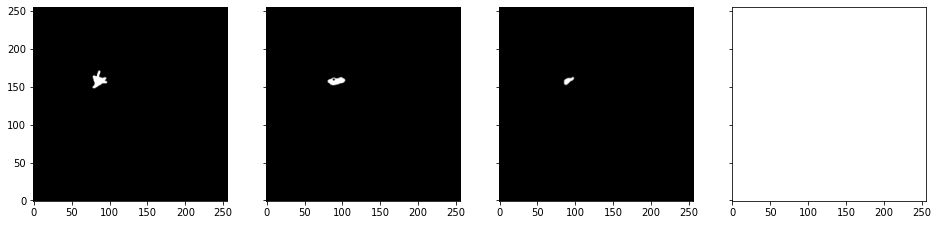

In [97]:
show_slices(slices_sep[1])

In [98]:
path_to_colon = Path.cwd().parent / "Task10_Colon" / 'labelsTr' 
all_colon_masks = list(path_to_colon.glob("**/*.nii.gz"))
colon_masks = []
for path in all_colon_masks:
    if not str(path).split("\\")[-1].startswith("._"):
        colon_masks.append(path)

In [99]:
VOLUME_NUMBER=10

In [100]:
slices_sep, slices_all = sample_masks(colon_masks[VOLUME_NUMBER], max_samples=None, 
                                      distinct_values=2, show = False,
                                     thresholds=[400])

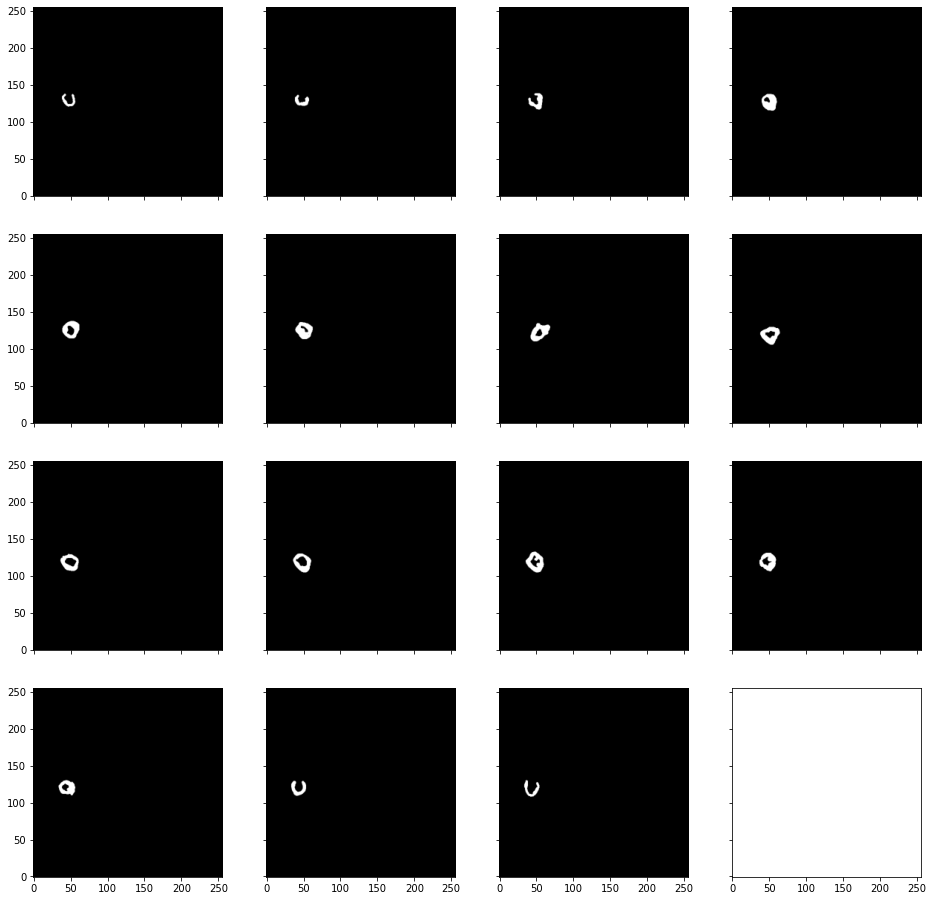

In [101]:
show_slices(slices_sep[1])

In [106]:
from pathlib import Path

In [110]:
path = Path.cwd().parent / "data" / "organs" / "heart" / "images"

In [114]:
path.glob("**/*.*")

<generator object Path.glob at 0x0000021D4219C7C8>